In [34]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image

<font size=4>
    
**Generator** <br><br>
因為我的random vector(z)是採用 latents x 1 x 1 (latents代表z的維度數) <br><br>
DCGAN是採用ConvTranspose2d進行上採樣的進行，也就是讓圖變大張。 <br><br>
MNIST圖片為28 x 28，一般上採樣通常是固定放大1倍。 <br><br>

1 x 1 → 上採樣 → 2 x 2 → 上採樣 → 4 x 4 → 上採樣 → 8 x 8 → 上採樣 → 16 x 16 → 上採樣 → 32 x 32<br><br>
   
所以不會變成28 x 28。<br><br>
    
所以我利用ConvTranspose2d的stride和pad的設計，讓上採樣可以非1倍放大，細節請看程式碼，我每一層輸出的大小有寫在備註。<br>
1 x 1 → ConvTranspose2d → 2 x 2 → ConvTranspose2d → 3 x 3 → ConvTranspose2d → 6 x 6 → ConvTranspose2d → 7 x 7 → ConvTranspose2d → 14 x 14 → ConvTranspose2d → 28 x 28 <br><br>
   

In [35]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        
class CBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class CBLR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBLR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class TCBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(TCBR, self).__init__(
            nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )                    
                         
                         

class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # input is random_Z,  state size. latents x 1 x 1 
            # going into a convolution
            TCBR(latents, 256, 4, 2, 1),  # state size. 256 x 2 x 2
            CBR(256, 128, 3, 1)
        )
        
        self.layer2= nn.Sequential(
            TCBR(128, 256, 4, 1, 0), # state size. 256 x 3 x 3
            TCBR(256, 256, 4, 2, 1), # state size. 256 x 6 x 6
            
        )
        self.layer3= nn.Sequential(
            TCBR(256, 128, 4, 1, 0), # state size. 256 x 7 x 7
            TCBR(128, 128, 4, 2, 1),  # state size. 256 x 14 x 14
            CBR(128, 128, 3, 1)
            # state size. 256 x 6 x 6

        )
        self.layer4= nn.Sequential(
            TCBR(128, 64, 4, 2, 1), # state size. 64 x 28 x 28
            CBR(64, 64, 3, 1),
            CBR(64, 64, 3, 1),
            nn.Conv2d(64, 1, 3, 1, 1), # state size. 1 x 28 x 28
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            CBLR(1, 32, 3, 2), # b*32*14*14
            CBLR(32, 64, 3, 1), # b*64*14*14
            CBLR(64, 128, 3, 2), # b*128*7*7
            CBLR(128, 128, 3, 2), # b*32*3*3
            CBLR(128, 64, 3, 2), # b*32*1*1
        )        
        self.fc = nn.Linear(64,2)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

In [36]:
# from torchvision.utils import save_image

flag_gpu = 1
# Number of workers for dataloader
workers = 8
# Batch size during training
batch_size = 100
# Number of training epochs
epochs = 50
# Learning rate for optimizers
lr = 0.0002

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
latent_dim = 100
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


#g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
#d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)

# Load data
train_set = datasets.MNIST('./dataset', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

GPU State: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch: 1/50] D_loss: 0.362 G_loss: 1.269
Generated images for epoch: 1


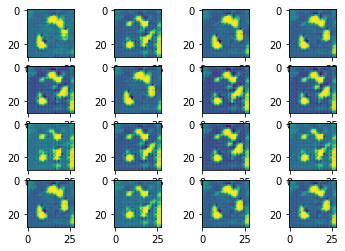

[Epoch: 2/50] D_loss: 0.190 G_loss: 1.989
Generated images for epoch: 2


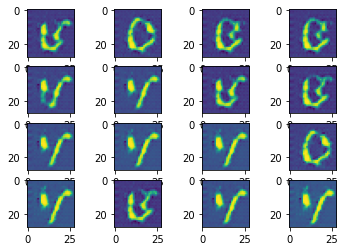

[Epoch: 3/50] D_loss: 0.165 G_loss: 2.204
Generated images for epoch: 3


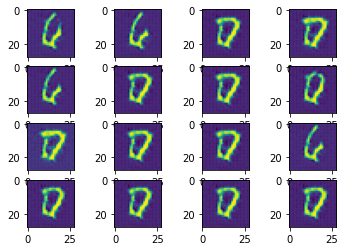

[Epoch: 4/50] D_loss: 0.258 G_loss: 1.826
Generated images for epoch: 4


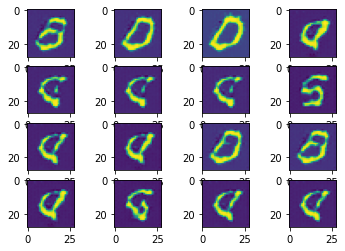

[Epoch: 5/50] D_loss: 0.325 G_loss: 1.566
Generated images for epoch: 5


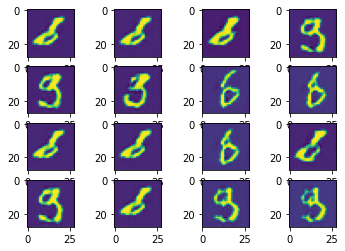

[Epoch: 6/50] D_loss: 0.329 G_loss: 1.615
Generated images for epoch: 6


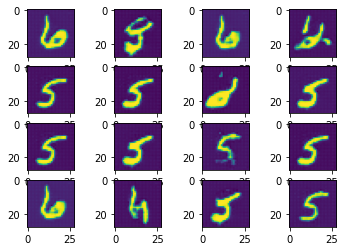

[Epoch: 7/50] D_loss: 0.271 G_loss: 1.722
Generated images for epoch: 7


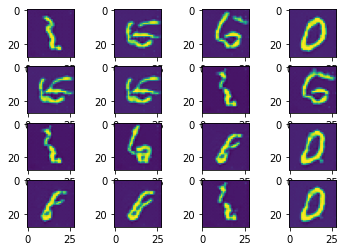

[Epoch: 8/50] D_loss: 0.282 G_loss: 1.699
Generated images for epoch: 8


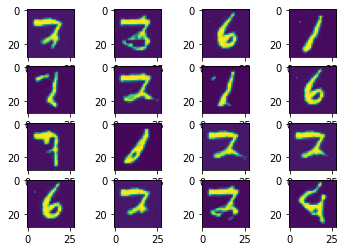

[Epoch: 9/50] D_loss: 0.309 G_loss: 1.580
Generated images for epoch: 9


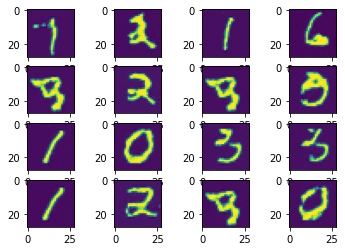

[Epoch: 10/50] D_loss: 0.339 G_loss: 1.528
Generated images for epoch: 10


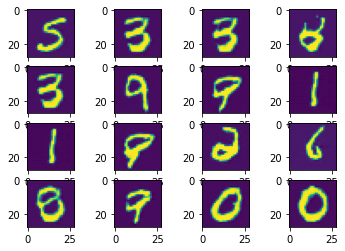

[Epoch: 11/50] D_loss: 0.310 G_loss: 1.620
Generated images for epoch: 11


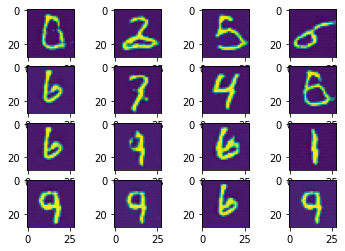

[Epoch: 12/50] D_loss: 0.281 G_loss: 1.745
Generated images for epoch: 12


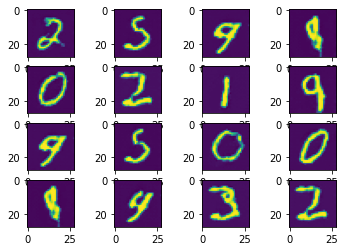

[Epoch: 13/50] D_loss: 0.273 G_loss: 1.788
Generated images for epoch: 13


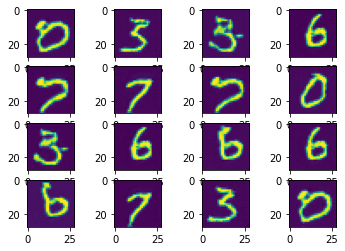

[Epoch: 14/50] D_loss: 0.311 G_loss: 1.665
Generated images for epoch: 14


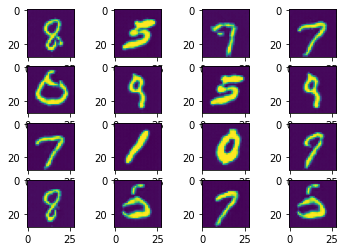

[Epoch: 15/50] D_loss: 0.346 G_loss: 1.516
Generated images for epoch: 15


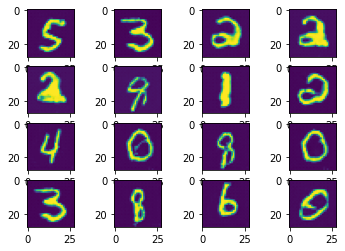

[Epoch: 16/50] D_loss: 0.317 G_loss: 1.603
Generated images for epoch: 16


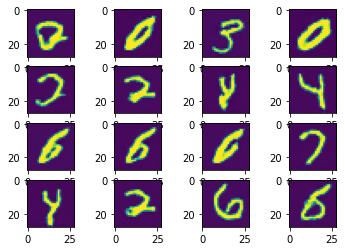

[Epoch: 17/50] D_loss: 0.323 G_loss: 1.602
Generated images for epoch: 17


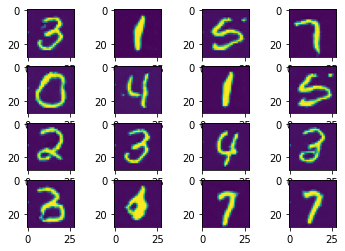

[Epoch: 18/50] D_loss: 0.327 G_loss: 1.639
Generated images for epoch: 18


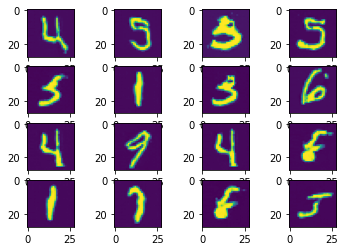

[Epoch: 19/50] D_loss: 0.272 G_loss: 1.839
Generated images for epoch: 19


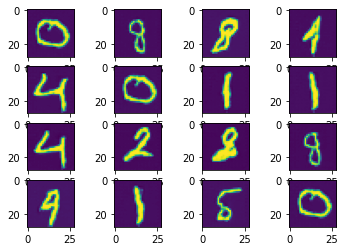

[Epoch: 20/50] D_loss: 0.267 G_loss: 1.877
Generated images for epoch: 20


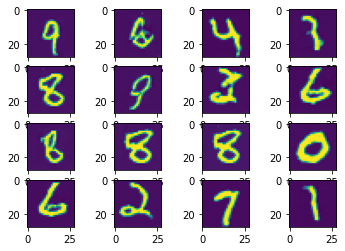

[Epoch: 21/50] D_loss: 0.255 G_loss: 1.892
Generated images for epoch: 21


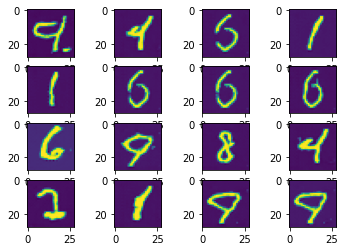

[Epoch: 22/50] D_loss: 0.278 G_loss: 1.840
Generated images for epoch: 22


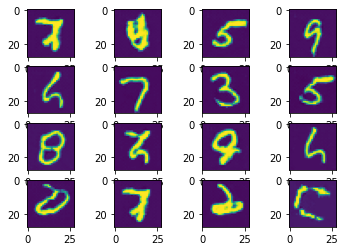

[Epoch: 23/50] D_loss: 0.275 G_loss: 1.858
Generated images for epoch: 23


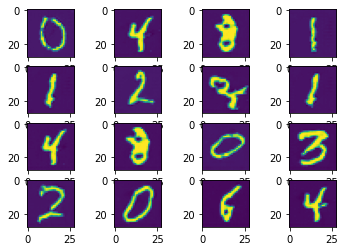

[Epoch: 24/50] D_loss: 0.272 G_loss: 1.855
Generated images for epoch: 24


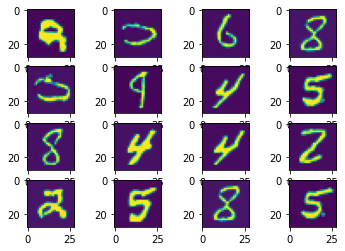

[Epoch: 25/50] D_loss: 0.228 G_loss: 2.091
Generated images for epoch: 25


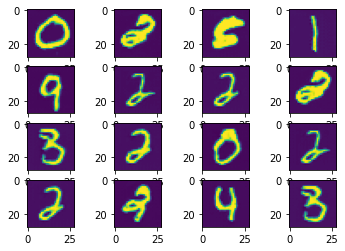

[Epoch: 26/50] D_loss: 0.269 G_loss: 1.980
Generated images for epoch: 26


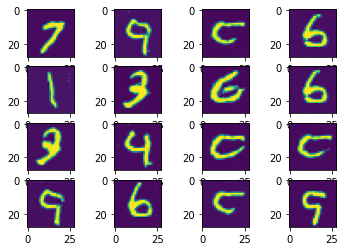

[Epoch: 27/50] D_loss: 0.278 G_loss: 1.899
Generated images for epoch: 27


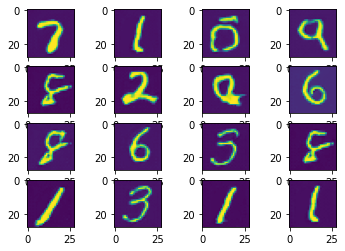

[Epoch: 28/50] D_loss: 0.283 G_loss: 1.850
Generated images for epoch: 28


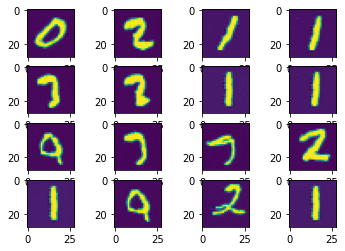

[Epoch: 29/50] D_loss: 0.274 G_loss: 1.886
Generated images for epoch: 29


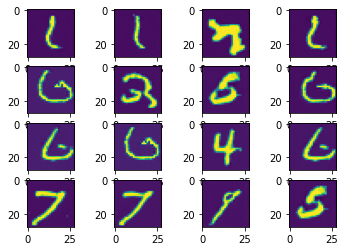

[Epoch: 30/50] D_loss: 0.207 G_loss: 2.176
Generated images for epoch: 30


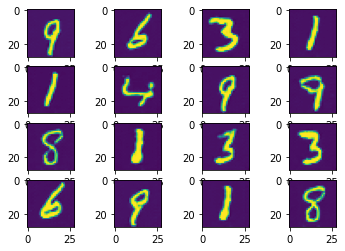

[Epoch: 31/50] D_loss: 0.256 G_loss: 2.009
Generated images for epoch: 31


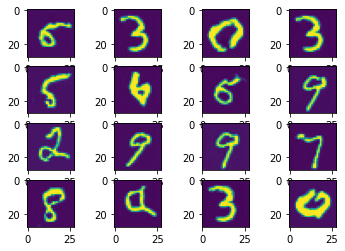

[Epoch: 32/50] D_loss: 0.276 G_loss: 1.919
Generated images for epoch: 32


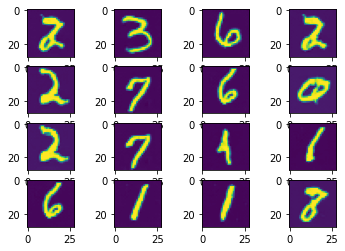

[Epoch: 33/50] D_loss: 0.302 G_loss: 1.874
Generated images for epoch: 33


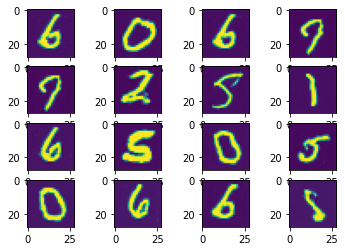

[Epoch: 34/50] D_loss: 0.282 G_loss: 1.858
Generated images for epoch: 34


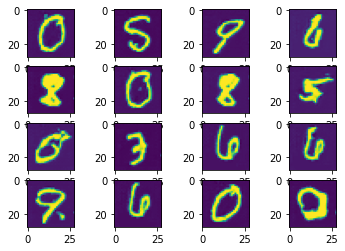

[Epoch: 35/50] D_loss: 0.223 G_loss: 2.179
Generated images for epoch: 35


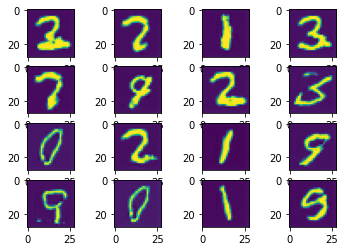

[Epoch: 36/50] D_loss: 0.256 G_loss: 2.021
Generated images for epoch: 36


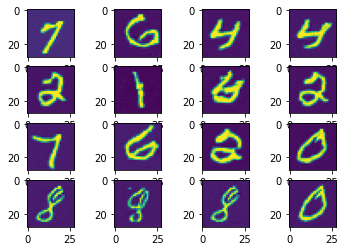

[Epoch: 37/50] D_loss: 0.286 G_loss: 1.930
Generated images for epoch: 37


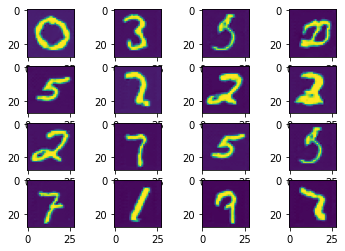

[Epoch: 38/50] D_loss: 0.273 G_loss: 1.913
Generated images for epoch: 38


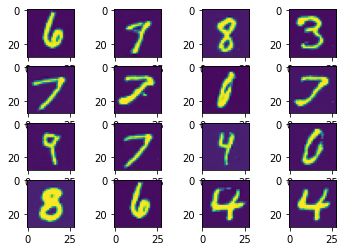

[Epoch: 39/50] D_loss: 0.246 G_loss: 2.089
Generated images for epoch: 39


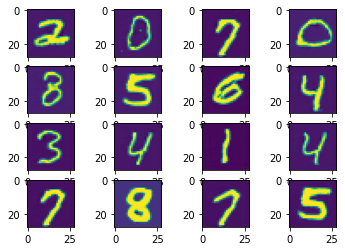

[Epoch: 40/50] D_loss: 0.227 G_loss: 2.154
Generated images for epoch: 40


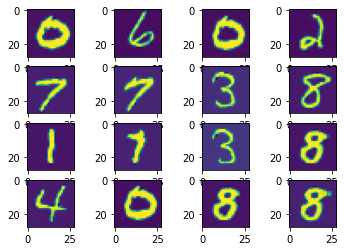

[Epoch: 41/50] D_loss: 0.220 G_loss: 2.170
Generated images for epoch: 41


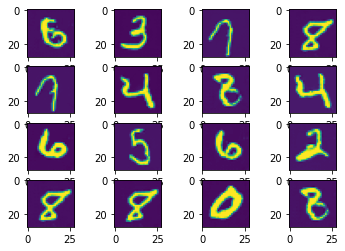

[Epoch: 42/50] D_loss: 0.215 G_loss: 2.232
Generated images for epoch: 42


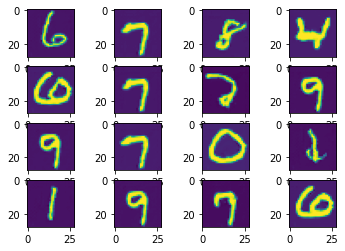

[Epoch: 43/50] D_loss: 0.269 G_loss: 1.992
Generated images for epoch: 43


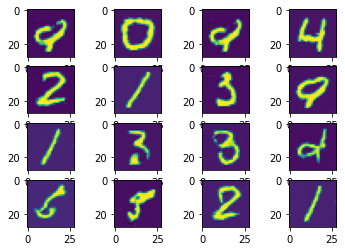

[Epoch: 44/50] D_loss: 0.271 G_loss: 1.979
Generated images for epoch: 44


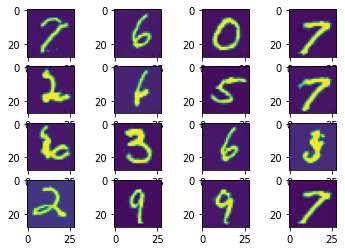

[Epoch: 45/50] D_loss: 0.268 G_loss: 2.015
Generated images for epoch: 45


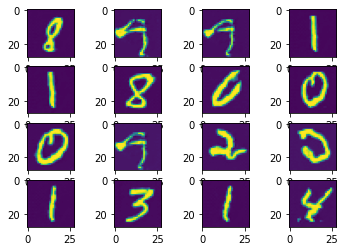

[Epoch: 46/50] D_loss: 0.253 G_loss: 2.122
Generated images for epoch: 46


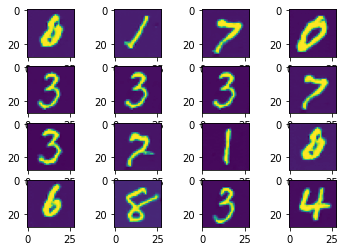

[Epoch: 47/50] D_loss: 0.252 G_loss: 2.060
Generated images for epoch: 47


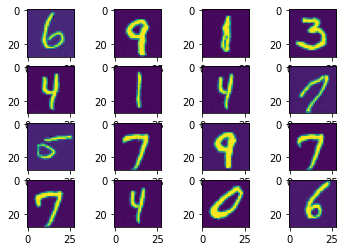

[Epoch: 48/50] D_loss: 0.263 G_loss: 2.056
Generated images for epoch: 48


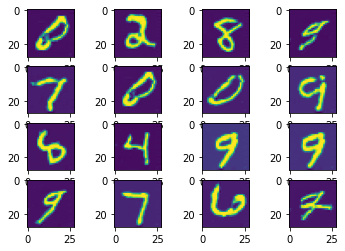

[Epoch: 49/50] D_loss: 0.259 G_loss: 2.082
Generated images for epoch: 49


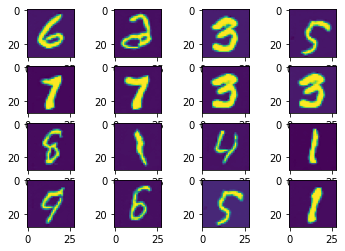

[Epoch: 50/50] D_loss: 0.247 G_loss: 2.135
Generated images for epoch: 50


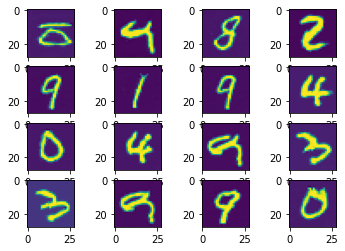

Model saved.
Training Finished.
Cost Time: 1675.5976994037628s


In [37]:
def show_images(images, epoch):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.savefig("Generator_epoch_{}.png".format(epoch))
# Train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g, total_loss_d = 0,0
    count_d = 0
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1

        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()
        # Sample noise as generator input
        noise = torch.randn(images.shape[0], latent_dim, 1, 1)
        noise = noise.to(device)
        
        # 因為Generator希望生成出來的圖片跟真的一樣，所以fake_label標註用 1
        fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device) # notice: label = 1


        # Generate a batch of images
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = adversarial_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value.item()) 
        

        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Zero the parameter gradients
        d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 因為Discriminator希望判斷哪些是真的那些是生成的，所以real_label資料標註用 1，fake_label標註用0。
        real_inputs = images.to(device) 
        real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)
#       learning by Discriminator
        real_loss = adversarial_loss(D(real_inputs),real_label)
        fake_loss = adversarial_loss(D(fake_inputs.detach()),fake_label)

        loss_d_value = (real_loss + fake_loss) / 2
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value.item())
        
       
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)
                
    #g_scheduler.step()
    #d_scheduler.step()
    
    
     

    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    if epoch % 1 == 0:
        print('Generated images for epoch: {}'.format(epoch))
        imgs_numpy = fake_inputs.data.cpu().numpy()
        show_images(imgs_numpy[:16],epoch)
        plt.show()

torch.save(G, 'DCGAN_Generator.pth')
torch.save(D, 'DCGAN_Discriminator.pth')
print('Model saved.')

print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))

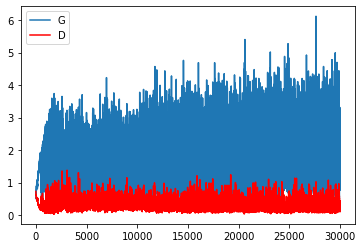

In [38]:
plt.plot(loss_g)
plt.plot(loss_d,'r')
plt.legend(['G','D'])
plt.show()

cuda:0


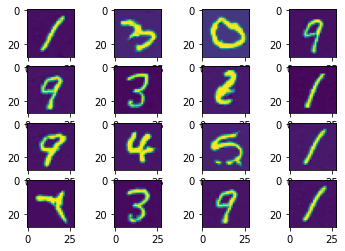

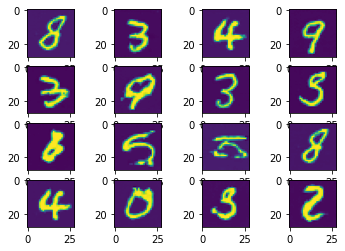

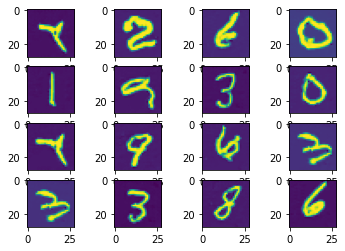

In [40]:
import torch
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.show()

flag_gpu = 1
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print(device)

G = torch.load('DCGAN_Generator.pth', map_location=device)
  
latent_dim = 100

## Exp:1
noise = torch.randn(20, latent_dim, 1, 1)
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])

## Exp:2
noise = torch.randn(20, latent_dim, 1, 1) *-10000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])


## Exp:3
noise = torch.randn(20, latent_dim, 1, 1) *50000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])